# Wide and Deep Neural Networks

By Charles Patterson

# Pre-processing

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import RMSprop
from keras.layers import Dense, Activation, Input
from keras.layers import Embedding, Flatten, concatenate
from keras.models import Model
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import RMSprop
from statsmodels.stats.contingency_tables import mcnemar
from sklearn.manifold import SpectralEmbedding
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import recall_score, confusion_matrix, accuracy_score, roc_curve, auc
from sklearn.manifold import TSNE
from sklearn.metrics import multilabel_confusion_matrix
from statsmodels.stats.contingency_tables import mcnemar

/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.ensemble.bagging module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.
  warnings.warn(message, FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.ensemble.base module is  deprecated in version 0.22 and will be removed in

In [2]:
df = pd.read_csv("US_Accidents_Dec19.csv")

In [3]:
delete_cols = ["index", "ID", "End_Lng", "End_Lat", "Description", "Country", "Number", "Civil_Twilight", "Nautical_Twilight",
              "Astronomical_Twilight", "Wind_Chill(F)", "Precipitation(in)", "TMC", "Wind_Direction", "Source",
              "Start_Lng", "Start_Lat", "Street", "Time_Zone", "Start_Time", "End_Time", "Weather_Timestamp",
              "Zipcode", "Airport_Code", 'County', 'Timezone', "City"]

In [4]:
for col in delete_cols:
    if col in df:
        del df[col]

In [5]:
df.dropna(inplace = True)
df.shape

(934428, 24)

In [6]:
all_cols = ['Severity', 'Distance', 'Side', 'State', 'Temperature',
       'Humidity', 'Pressure', 'Visibility', 'Wind_Speed',
       'Weather_Condition', 'Amenity', 'Bump', 'Crossing', 'Give_Way',
       'Junction', 'No_Exit', 'Railway', 'Roundabout', 'Station', 'Stop',
       'Traffic_Calming', 'Traffic_Signal', 'Turning_Loop', 'Sunrise_Sunset']
cat_cols = ['Side', 'State', 'Weather_Condition', 'Amenity', 'Bump', 'Crossing', 
        'Give_Way', 'Junction', 'No_Exit', 'Railway', 'Roundabout', 'Station', 'Stop', 'Traffic_Calming', 
        'Traffic_Signal', 'Turning_Loop', 'Sunrise_Sunset']
int_cols = ["Distance(mi)", 'Temperature(F)', 'Humidity(%)', 'Pressure(in)', 'Visibility(mi)', 'Wind_Speed(mph)']

In [7]:
columns = {}
for key in df.columns: 
    for value in all_cols: 
        columns[key] = value 
        all_cols.remove(value) 
        break  
df = df.rename(columns=columns)
all_cols = df.columns

In [8]:
df[cat_cols[3:-1]] = df[cat_cols[3:-1]].astype('str')

In [9]:
feature_columns = [x+'_int' for x in all_cols]
feature_columns.remove('Severity_int')

encoders = dict()
for col in all_cols:  
    if type(df[col]) == 'str':
        df[col] = df[col].str.strip()
    if col == 'Severity':
        tmp = LabelEncoder()
        df[col] = tmp.fit_transform(df[col])
    else:
        encoders[col] = LabelEncoder()
        df[col+'_int'] = encoders[col].fit_transform(df[col])

In [10]:
y = df["Severity"]
if "Severity" in df:
    del df["Severity"]

In [11]:
ros = RandomOverSampler()
X, y = ros.fit_resample(df, y)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [12]:
ohe = OneHotEncoder(sparse = False)
y = ohe.fit_transform(y.reshape(-1,1))

In [13]:
#A utility function
def transform(pred):
    l = len(pred)
    for i in range(l):
        pred[np.argmax(pred[i])] = 1
        pred[i] = np.round(pred[i])
    return pred

In this final df, I have 25 features and just shy of a million data points.  Many of these features are boolean values for whether there exists a type of traffic hazard. Furthermore there is some data about the location of these various car crashes.  On the numeric side, there is some data about the specifics of the weather like Pressure, Wind Speed, Tempature.  In addition, there is some data about the specifications of the crash like the distance it covered.

## Cross Products

In [14]:
print(cat_cols)

['Side', 'State', 'Weather_Condition', 'Amenity', 'Bump', 'Crossing', 'Give_Way', 'Junction', 'No_Exit', 'Railway', 'Roundabout', 'Station', 'Stop', 'Traffic_Calming', 'Traffic_Signal', 'Turning_Loop', 'Sunrise_Sunset']


Looking at all of the cat_cols to choose from, there is a lot to play around with in this dataset.  I am thinking any of the variables between Amenity to Turning_Loop all can be cross products of each other because they indicate various encounters you might have while driving.  If crossed, these could reveal an interaction effect between two variables that could be worth looking into.  I also think that looking into weather condition and state would be good to look into because if you're are driving in unfamiliar (i.e. Texas and Snow) then there will likely be more frequent car crashes, and worse car crashes.  Since this is enough to play around with, I don't think I am going to try and cross States or other location variables with the driving hazard variables, but that could also reveal some interesting results.

In [15]:
#All that being said, I want to try to use these three sets of cross product features:
cross_columns1 = [['State','Weather_Condition'], #Certain states will be more familiar with certain weather 
                                                 #patterns than others.
                 ['Traffic_Signal','Sunrise_Sunset'], #If the sun's in your eyes while driving, this sucks.
                 ['Stop', 'Railway']] #If you're at a railway, and there's a stop sign, sometimes this gets weird.
                                      #Also people generally get weird around railroads


cross_columns2 = [['Railway','Traffic_Signal'], #Again, people and railways are weird, and 
                                                #traffic lights make them espically so.
                 ['Stop', 'Traffic_Calming'], #If traffic is not calming and there is a stop, this could be 
                                              #interesting.  Furthermore, I think this lack of both could increase 
                                              #car crash severity.
                 ['No_Exit', 'Side']] #Depending on what side of the road there on, 
                                      #and if there is an exit on the highway this could be interesting.
                 
cross_columns3 = [['Side', 'Crossing'], #I don't know that this is going to do much, but I think there could be 
                                        #something to how people cross the street.
                 ['Traffic_Signal', 'Weather_Condition'], #If it's rainy or otherwise slick, this is v dangerous
                 ['Turning_Loop', 'Amenity']] #Likely only going to see this is a neighborhood, but I think turning 
                                              #turning loop generally will allow for less severe crashes.

## Measuring Preformance

I went back and forth on this quite a bit, but I decided accuracy was probably going to be best for this dataset.  However, there are many different case uses for this dataset.  For example, if I am using this data for the benefit of EMS, under guessing the severity of a wreck has much higher consequences than over estimating.  However, I am am going to assume I am working for a company like Waze and I am trying to give people the fastest directions from point A to point B.  Becuase of this, I need to know about how severe, and how long a delay any given wreck will be.  Therefore, just the difference in consequence between under estimating and over estimating are roughly equal.  Due to this, I am going to use accuracy as my metric.

## Splitting the Data

In [16]:
cols = np.hstack((all_cols[1:], feature_columns))

Given the size of my dataset (2.5M obs.) I believe it is fair to preform a basic 80/20 test split.  However, just to be cautious, I have chosen to also stratify by y.  I did have to do some over sampling because I had very few cases of Severity = 1 or Severity = 4.

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify = y)
X_train = pd.DataFrame(X_train, columns = cols)
X_test = pd.DataFrame(X_test, columns = cols)

# Modeling

For each of these models, I have largely kept the same structure and tweaked some things here and there.  Largely, I used a different set of cross columns (1, 2, and 3) for my various wide branches.  For the deep side, I opted to vary the dropout rate and whether I was changing the drop out rate for each layer in the network.  

For the number of layers in the network, in model 1 I have 3 layers, model 2 has 4 layers and model 3 has 5 layers.

### Model 1

In [18]:
# specify crossed columns
cross_columns = cross_columns1

# global model variables
all_inputs = []

# wide branch variables
all_wide_branch_outputs = []
N_list = []

# obtain integer encoded crossed embedings and data
X_ints_train = []
X_ints_test = []

for cols in cross_columns:
    enc = LabelEncoder()

    X_crossed_train = X_train[cols].apply(lambda x: '_'.join(x), axis=1)
    X_crossed_test = X_test[cols].apply(lambda x: '_'.join(x), axis=1)

    enc.fit(np.hstack((X_crossed_train.values,  X_crossed_test.values)))
    X_crossed_train = enc.transform(X_crossed_train)
    X_crossed_test = enc.transform(X_crossed_test)

    X_ints_train.append( X_crossed_train )
    X_ints_test.append( X_crossed_test )

    N_list.append(max(X_ints_train[-1]+1))


for col in feature_columns:
    X_ints_train.append(X_train[col].values )
    X_ints_test.append(X_test[col].values )

# create the wide branches
for i,n in enumerate(N_list):
    inputs = Input(shape=(1,),dtype='int32', name = '_'.join(cross_columns[i]))
    all_inputs.append(inputs)
    x = Embedding(input_dim=n, 
                  output_dim=int(np.sqrt(n)), 
                  input_length=1, name = '_'.join(cross_columns[i])+'_embed')(inputs)
    x = Flatten()(x)
    all_wide_branch_outputs.append(x)
    
# merge the wide branches together
wide_branch = concatenate(all_wide_branch_outputs, name='wide_concat')
wide_branch = Dense(units=4,activation='sigmoid',name='wide_combined')(wide_branch)

# deep branch variables 
all_deep_branch_outputs = []

# create the deep embedings
for col in feature_columns:
    N = max(X_train[col]+1)
    
    inputs = Input(shape=(1,),dtype='int32', name=col)
    all_inputs.append(inputs)
    x = Embedding(input_dim=N, 
                  output_dim=int(np.sqrt(N)), 
                  input_length=1, name=col+'_embed')(inputs)
    x = Flatten()(x)
    all_deep_branch_outputs.append(x)
    
# merge the deep branches together
deep_branch = concatenate(all_deep_branch_outputs)
deep_branch = Dense(units=128,activation='relu')(deep_branch)
deep_branch = Dropout(0.2, seed=32)(deep_branch)
deep_branch = Dense(units=64,activation='relu')(deep_branch)
deep_branch = Dropout(0.4, seed=32)(deep_branch)
deep_branch = Dense(units=16,activation='relu')(deep_branch)

# merge wide and deep together
final_branch = concatenate([wide_branch, deep_branch],name='concat_deep_wide')
final_branch = Dense(units=4,activation='sigmoid',name='combined')(final_branch)

# gen model
model1 = Model(inputs=all_inputs, outputs=final_branch)

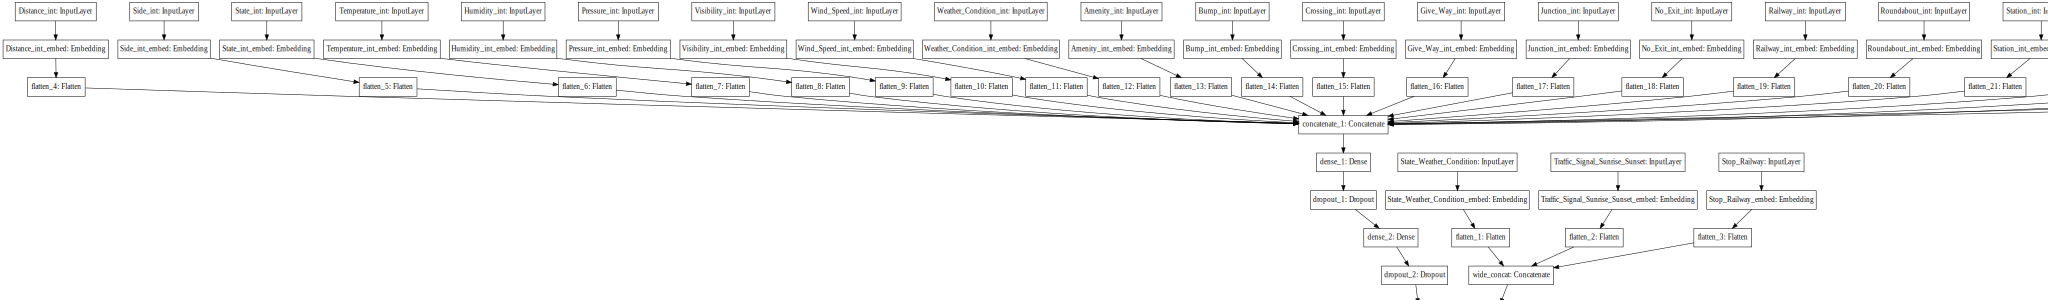

In [19]:
SVG(model_to_dot(model1).create(prog='dot', format='svg'))

In [20]:
%%time

# compile our model
model1.compile(optimizer='adam',
              loss='mean_squared_error',
              metrics=['accuracy'])

model1.save_weights('model_1_weights.h5')

model1.load_weights('model_1_weights.h5')
history = model1.fit(   X_ints_train,
                        y_train, 
                        epochs=5, 
                        batch_size=32, 
                        verbose=1, 
                        validation_data = (X_ints_test, y_test)
)

pred = model1.predict(X_ints_test)
pred = transform(pred)
conf_matrix = multilabel_confusion_matrix(y_test, pred)
print("-- CONFUSION MATRIX\n {} --".format(conf_matrix))

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 2000937 samples, validate on 500235 samples
Epoch 1/5
2000937/2000937 [==============================] - 333s 166us/step - loss: 0.0618 - accuracy: 0.8191 - val_loss: 0.0522 - val_accuracy: 0.8443
Epoch 2/5
2000937/2000937 [==============================] - 333s 166us/step - loss: 0.0521 - accuracy: 0.8465 - val_loss: 0.0491 - val_accuracy: 0.8548
Epoch 3/5
2000937/2000937 [==============================] - 329s 164us/step - loss: 0.0497 - accuracy: 0.8534 - val_loss: 0.0479 - val_accuracy: 0.8580
Epoch 4/5
2000937/2000937 [==============================] - 315s 158us/step - loss: 0.0486 - accuracy: 0.8565 - val_loss: 0.0470 - val_accuracy: 0.8596
Epoch 5/5
2000937/2000937 [==============================] - 315s 157us/step - loss: 0.0479 - accuracy: 0.8583 - val_loss: 0.0466 - val_accuracy: 0.8612
-- CONFUSION MATRIX
 [[[374928    248]
  [     0 125059]]

 [[358529  16647]
  [ 50655  74404]]

 [[324717  50459]
  [ 18291 106768]]

 [[374015   1162]
  [  1470 123588]]] --
CPU ti

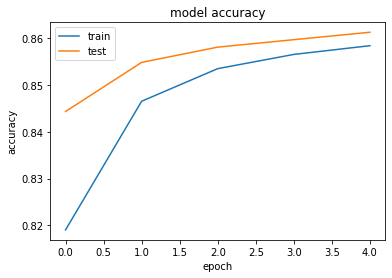

In [21]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### Model 2

In [22]:
# specify crossed columns
cross_columns = cross_columns2

# global model variables
all_inputs = []

# wide branch variables
all_wide_branch_outputs = []
N_list = []

# obtain integer encoded crossed embedings and data
X_ints_train = []
X_ints_test = []

for cols in cross_columns:
    enc = LabelEncoder()

    X_crossed_train = X_train[cols].apply(lambda x: '_'.join(x), axis=1)
    X_crossed_test = X_test[cols].apply(lambda x: '_'.join(x), axis=1)

    enc.fit(np.hstack((X_crossed_train.values,  X_crossed_test.values)))
    X_crossed_train = enc.transform(X_crossed_train)
    X_crossed_test = enc.transform(X_crossed_test)

    X_ints_train.append( X_crossed_train )
    X_ints_test.append( X_crossed_test )

    N_list.append(max(X_ints_train[-1]+1))


for col in feature_columns:
    X_ints_train.append(X_train[col].values )
    X_ints_test.append(X_test[col].values )

# create the wide branches
for i,n in enumerate(N_list):
    inputs = Input(shape=(1,),dtype='int32', name = '_'.join(cross_columns[i]))
    all_inputs.append(inputs)
    x = Embedding(input_dim=n, 
                  output_dim=int(np.sqrt(n)), 
                  input_length=1, name = '_'.join(cross_columns[i])+'_embed')(inputs)
    x = Flatten()(x)
    all_wide_branch_outputs.append(x)
    
# merge the wide branches together
wide_branch = concatenate(all_wide_branch_outputs, name='wide_concat')
wide_branch = Dense(units=4,activation='sigmoid',name='wide_combined')(wide_branch)

# deep branch variables 
all_deep_branch_outputs = []

# create the deep embedings
for col in feature_columns:
    N = max(X_train[col]+1)
    
    inputs = Input(shape=(1,),dtype='int32', name=col)
    all_inputs.append(inputs)
    x = Embedding(input_dim=N, 
                  output_dim=int(np.sqrt(N)), 
                  input_length=1, name=col+'_embed')(inputs)
    x = Flatten()(x)
    all_deep_branch_outputs.append(x)
    
# merge the deep branches together
deep_branch = concatenate(all_deep_branch_outputs)
deep_branch = Dense(units=256,activation='relu')(deep_branch)
deep_branch = Dropout(0.1, seed=32)(deep_branch)
deep_branch = Dense(units=128,activation='relu')(deep_branch)
deep_branch = Dropout(0.2, seed=32)(deep_branch)
deep_branch = Dense(units=64,activation='relu')(deep_branch)
deep_branch = Dropout(0.4, seed=32)(deep_branch)
deep_branch = Dense(units=16,activation='relu')(deep_branch)

# merge wide and deep together
final_branch = concatenate([wide_branch, deep_branch],name='concat_deep_wide')
final_branch = Dense(units=4,activation='sigmoid',name='combined')(final_branch)

# gen model
model2 = Model(inputs=all_inputs, outputs=final_branch)

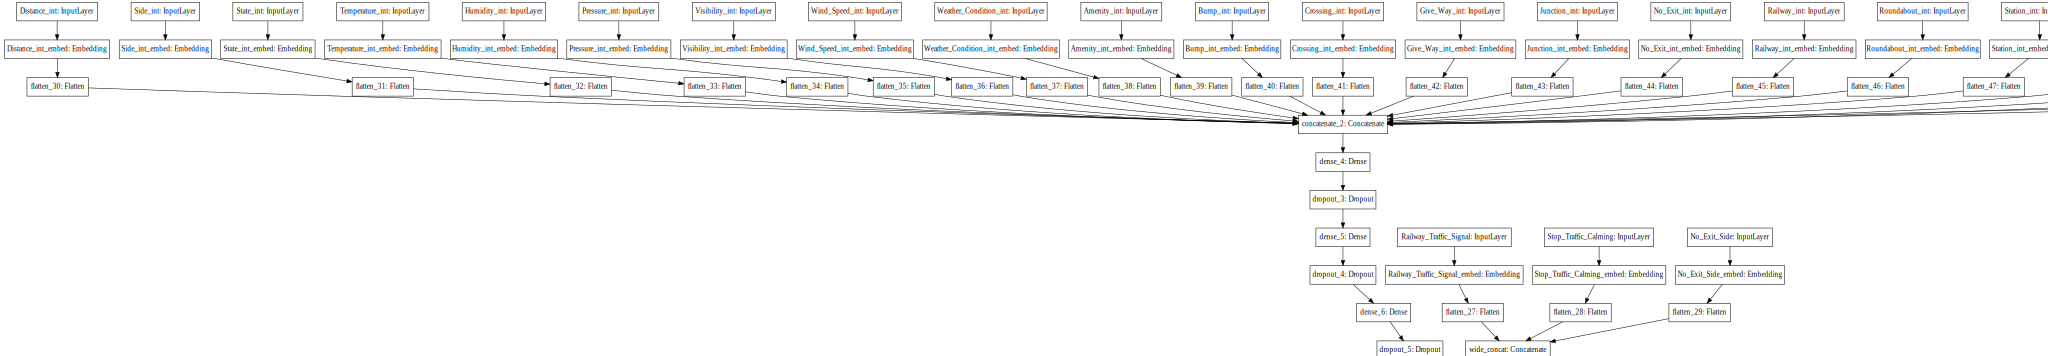

In [23]:
SVG(model_to_dot(model2).create(prog='dot', format='svg'))

In [24]:
%%time

# compile our model
model2.compile(optimizer='adam',
              loss='mean_squared_error',
              metrics=['accuracy'])

model2.save_weights('model_2_weights.h5')

model2.load_weights('model_2_weights.h5')
history = model2.fit(   X_ints_train,
                        y_train, 
                        epochs=5, 
                        batch_size=32, 
                        verbose=1, 
                        validation_data = (X_ints_test, y_test)
)

pred = model2.predict(X_ints_test)
pred = transform(pred)
conf_matrix = multilabel_confusion_matrix(y_test, pred)
print("-- CONFUSION MATRIX\n {} --".format(conf_matrix))

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 2000937 samples, validate on 500235 samples
Epoch 1/5
2000937/2000937 [==============================] - 333s 166us/step - loss: 0.0590 - accuracy: 0.8273 - val_loss: 0.0499 - val_accuracy: 0.8508
Epoch 2/5
2000937/2000937 [==============================] - 330s 165us/step - loss: 0.0495 - accuracy: 0.8531 - val_loss: 0.0474 - val_accuracy: 0.8590
Epoch 3/5
2000937/2000937 [==============================] - 329s 165us/step - loss: 0.0477 - accuracy: 0.8584 - val_loss: 0.0468 - val_accuracy: 0.8605
Epoch 4/5
2000937/2000937 [==============================] - 330s 165us/step - loss: 0.0468 - accuracy: 0.8610 - val_loss: 0.0462 - val_accuracy: 0.8620
Epoch 5/5
2000937/2000937 [==============================] - 332s 166us/step - loss: 0.0461 - accuracy: 0.8629 - val_loss: 0.0460 - val_accuracy: 0.8630
-- CONFUSION MATRIX
 [[[374652    524]
  [     0 125059]]

 [[353008  22168]
  [ 44666  80393]]

 [[332481  42695]
  [ 24841 100218]]

 [[373832   1345]
  [   667 124391]]] --
CPU ti

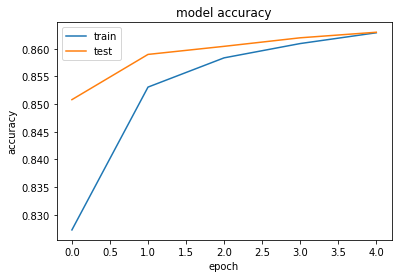

In [25]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### Model 3

In [26]:
# specify crossed columns
cross_columns = cross_columns3

# global model variables
all_inputs = []

# wide branch variables
all_wide_branch_outputs = []
N_list = []

# obtain integer encoded crossed embedings and data
X_ints_train = []
X_ints_test = []

for cols in cross_columns:
    enc = LabelEncoder()

    X_crossed_train = X_train[cols].apply(lambda x: '_'.join(x), axis=1)
    X_crossed_test = X_test[cols].apply(lambda x: '_'.join(x), axis=1)

    enc.fit(np.hstack((X_crossed_train.values,  X_crossed_test.values)))
    X_crossed_train = enc.transform(X_crossed_train)
    X_crossed_test = enc.transform(X_crossed_test)

    X_ints_train.append( X_crossed_train )
    X_ints_test.append( X_crossed_test )

    N_list.append(max(X_ints_train[-1]+1))


for col in feature_columns:
    X_ints_train.append(X_train[col].values )
    X_ints_test.append(X_test[col].values )

# create the wide branches
for i,n in enumerate(N_list):
    inputs = Input(shape=(1,),dtype='int32', name = '_'.join(cross_columns[i]))
    all_inputs.append(inputs)
    x = Embedding(input_dim=n, 
                  output_dim=int(np.sqrt(n)), 
                  input_length=1, name = '_'.join(cross_columns[i])+'_embed')(inputs)
    x = Flatten()(x)
    all_wide_branch_outputs.append(x)
    
# merge the wide branches together
wide_branch = concatenate(all_wide_branch_outputs, name='wide_concat')
wide_branch = Dense(units=4,activation='sigmoid',name='wide_combined')(wide_branch)

# deep branch variables 
all_deep_branch_outputs = []

# create the deep embedings
for col in feature_columns:
    N = max(X_train[col]+1)
    
    inputs = Input(shape=(1,),dtype='int32', name=col)
    all_inputs.append(inputs)
    x = Embedding(input_dim=N, 
                  output_dim=int(np.sqrt(N)), 
                  input_length=1, name=col+'_embed')(inputs)
    x = Flatten()(x)
    all_deep_branch_outputs.append(x)
    
# merge the deep branches together
deep_branch = concatenate(all_deep_branch_outputs)
deep_branch = Dense(units=512,activation='relu')(deep_branch)
deep_branch = Dropout(0.05, seed=32)(deep_branch)
deep_branch = Dense(units=256,activation='relu')(deep_branch)
deep_branch = Dropout(0.1, seed=32)(deep_branch)
deep_branch = Dense(units=128,activation='relu')(deep_branch)
deep_branch = Dropout(0.2, seed=32)(deep_branch)
deep_branch = Dense(units=64,activation='relu')(deep_branch)
deep_branch = Dropout(0.4, seed=32)(deep_branch)
deep_branch = Dense(units=16,activation='relu')(deep_branch)

# merge wide and deep together
final_branch = concatenate([wide_branch, deep_branch],name='concat_deep_wide')
final_branch = Dense(units=4,activation='sigmoid',name='combined')(final_branch)

# gen model
model3 = Model(inputs=all_inputs, outputs=final_branch)

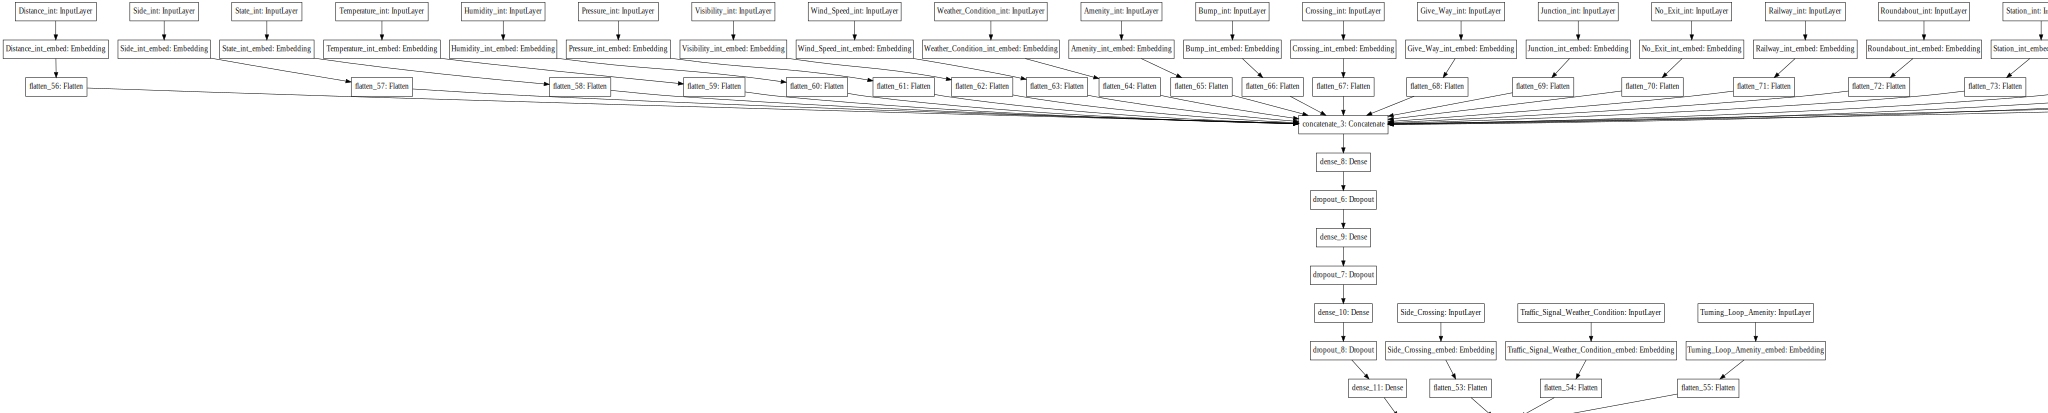

In [27]:
SVG(model_to_dot(model3).create(prog='dot', format='svg'))

In [28]:
# compile our model
model3.compile(optimizer='adam',
              loss='mean_squared_error',
              metrics=['accuracy'])

model3.save_weights('model_3_weights.h5')

model3.load_weights('model_3_weights.h5')
history = model3.fit(   X_ints_train,
                        y_train, 
                        epochs=5, 
                        batch_size=32, 
                        verbose=1, 
                        validation_data = (X_ints_test, y_test)
)


pred = model3.predict(X_ints_test)
pred = transform(pred)
conf_matrix = multilabel_confusion_matrix(y_test,pred)
print("-- CONFUSION MATRIX\n {} --".format(conf_matrix))

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 2000937 samples, validate on 500235 samples
Epoch 1/5
2000937/2000937 [==============================] - 438s 219us/step - loss: 0.0566 - accuracy: 0.8337 - val_loss: 0.0491 - val_accuracy: 0.8539
Epoch 2/5
2000937/2000937 [==============================] - 440s 220us/step - loss: 0.0484 - accuracy: 0.8564 - val_loss: 0.0474 - val_accuracy: 0.8587
Epoch 3/5
2000937/2000937 [==============================] - 449s 224us/step - loss: 0.0470 - accuracy: 0.8603 - val_loss: 0.0471 - val_accuracy: 0.8594
Epoch 4/5
2000937/2000937 [==============================] - 466s 233us/step - loss: 0.0461 - accuracy: 0.8631 - val_loss: 0.0461 - val_accuracy: 0.8622
Epoch 5/5
2000937/2000937 [==============================] - 448s 224us/step - loss: 0.0454 - accuracy: 0.8658 - val_loss: 0.0456 - val_accuracy: 0.8642
-- CONFUSION MATRIX
 [[[374962    214]
  [   256 124803]]

 [[357385  17791]
  [ 48025  77034]]

 [[328074  47102]
  [ 19955 105104]]

 [[374137   1040]
  [  1315 123743]]] --


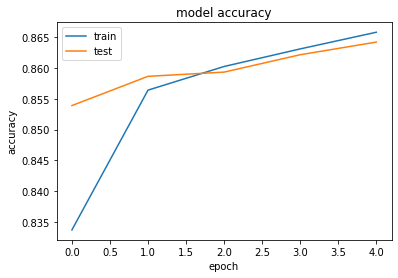

In [29]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Compare MLP to Wide and Deep

Model 3 out of all the models did preform the best.  Although as seen in the graph above, the model may be slightly over-trained.  However, since it did the best on my test set of all the 3 models, I am going to compare model 3 to an MLP for my best model.

In [30]:
#An MLP
#I got this from https://keras.io/examples/mnist_mlp/
model = Sequential()
model.add(Dense(128, activation='relu', input_shape=(46,)))
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(4, activation='softmax'))

model.summary()

enc = LabelEncoder()
for col in cat_cols:
    X_train[col] = enc.fit_transform(X_train[col])
    X_test[col] = enc.fit_transform(X_test[col])

model.compile(optimizer='adam',
              loss='mean_squared_error',
              metrics=['accuracy'])

history = model.fit(X_train, y_train,
                    batch_size=32,
                    epochs=5,
                    verbose=1,
                    validation_data=(X_test, y_test))

yhat = model.predict(X_test)
yhat = transform(yhat)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_13 (Dense)             (None, 128)               6016      
_________________________________________________________________
dropout_10 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 64)                8256      
_________________________________________________________________
dropout_11 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_15 (Dense)             (None, 16)                1040      
_________________________________________________________________
dropout_12 (Dropout)         (None, 16)                0         
_________________________________________________________________
dense_16 (Dense)             (None, 4)                

In [31]:
#Got this idea from https://machinelearningmastery.com/mcnemars-test-for-machine-learning/
def mcnemarTest(table):
    # calculate mcnemar test
    result = mcnemar(table, exact=True)
    # summarize the finding
    print('statistic=%.3f, p-value=%.3f' % (result.statistic, result.pvalue))
    # interpret the p-value
    alpha = 0.05
    if result.pvalue > alpha:
        print('Same proportions of errors (fail to reject H0)')
    else:
        print('Different proportions of errors (reject H0)')

In [32]:
A = B = C = D = 0
yhat = np.array(yhat)
pred = np.array(pred)
y_test = np.array(y_test)
for i in range(len(yhat)):
    if (np.array_equal(yhat[i], pred[i])):
        if np.array_equal(pred[i], y_test[i]):
            A += 1
        else:
            B += 1
    else:
        if np.array_equal(pred[i], y_test[i]):
            C += 1
        else:
            D += 1

table = [[A,B], [C,D]]
mcnemarTest(table)

statistic=3893.000, p-value=0.000
Different proportions of errors (reject H0)


At a significance level of 0.05 and a p-value of 0.000, there is sufficient evidence to conclude that the difference in means of the prediction accuracy metric for the Wide and Deep Network differ from the MLP.